In [408]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import gc
from sklearn.preprocessing import LabelEncoder
from pandas.core.dtypes.dtypes import CategoricalDtype

warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

# label encoding
le = LabelEncoder()

In [409]:
df_train_dtypes = {'building_id': np.int16, 'meter': np.int8, 'meter_reading': np.float32}
df_test_dtypes = {'building_id': np.int16, 'meter': np.int8}
df_building_metadata_dtypes = {'site_id': np.int8, 'building_id': np.uint16, 'square_feet': np.int32, 'year_built': np.float32, 'floor_count': np.float32}
df_weather_dtypes = {'site_id': np.int8, 'air_temperature': np.float32, 'cloud_coverage': np.float32, 'dew_temperature': np.float32,
                     'precip_depth_1_hr': np.float32, 'sea_level_pressure': np.float32, 'wind_direction': np.float32, 'wind_speed': np.float32}

# import - second run you can skip
building = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv', dtype=df_building_metadata_dtypes)
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv', dtype=df_weather_dtypes)
weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv', dtype=df_weather_dtypes)
train = pd.read_csv('../input/ashrae-energy-prediction/train.csv', dtype=df_train_dtypes)
test = pd.read_csv('../input/ashrae-energy-prediction/test.csv', dtype=df_test_dtypes)

train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [410]:
# add features we are 100% sure about
def accpetedFeatures(df):
    #time_stamps
    df["timestamp"] = pd.to_datetime(df["timestamp"])    
    df.rename(columns={"square_feet": "log_square_feet"}, inplace=True)
    df['log_square_feet'] = np.float16(np.log(df['log_square_feet']))
    
for df in [train, test]:
    df = accpetedFeatures(df)    

In [411]:
# Set types category types
for df in [train, test]:
    df["primary_use"] = df["primary_use"].astype("category")
    df["meter"] = df["meter"].astype("category")
    df["site_id"] = df["site_id"].astype("category")
    df["building_id"] = df["building_id"].astype("category")

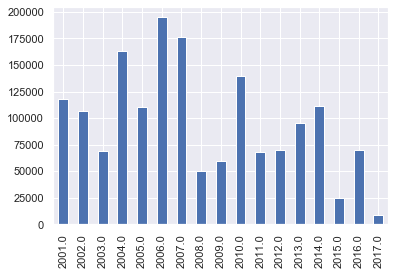

In [413]:
# note some building are built in the future!
train[ train['year_built'] > 2000]['year_built'].value_counts().sort_index().plot(kind='bar')

In [414]:
# Creating building_age

def imputeYearBuilt(df):
    # set age of building to mediam of site_id
    # else if set ot overall median
    year_built_median = df['year_built'].median()
    # Set all year_built NaNs to site mean for year_built
    for i, i_median in df.groupby(['site_id'])['year_built'].mean().items():
        if not np.isnan(i_median):
            df.loc[(df['year_built'].isnull()) & (df['site_id'] == i), 'year_built'] = i_median
        else:
            df.loc[(df['year_built'].isnull()) & (df['site_id'] == i), 'year_built'] = year_built_median
    
for df in [train, test]:
    imputeYearBuilt(df)
    df['building_age'] = np.uint8(df['year_built']-1900)
    
print(train.groupby(['site_id'])['building_age'].describe())
gc.collect();


             count       mean        std   min   25%    50%    75%    max
site_id                                                                  
0        1076662.0  96.309126  14.322800  68.0  85.0  101.0  107.0  116.0
1         553357.0  60.398303  28.233491   0.0  56.0   60.0   70.0  107.0
2        2530312.0  73.648397  21.521243   7.0  64.0   73.0   88.0  114.0
3        2370097.0  61.244291  24.810568   0.0  61.0   61.0   61.0  117.0
4         746746.0  53.364929  31.687953   3.0  24.0   54.0   70.0  116.0
5         781776.0  62.595506  22.032023  19.0  66.0   76.0   76.0  113.0
6         668133.0  69.000000   0.000000  69.0  69.0   69.0   69.0   69.0
7         366681.0  61.256065  18.781965  11.0  55.0   64.0   70.0   95.0
8         567915.0  69.000000   0.000000  69.0  69.0   69.0   69.0   69.0
9        2679323.0  69.000000   0.000000  69.0  69.0   69.0   69.0   69.0
10        411407.0  69.000000   0.000000  69.0  69.0   69.0   69.0   69.0
11        119459.0  69.000000   0.0000

In [415]:
# Fill NaNs
fill_w_neg_one = []
fill_w_zero = ['floor_count']
fill_w_popular = []
fill_w_mean = ['cloud_coverage','building_age','air_temperature','dew_temperature', 
              "precip_depth_1_hr", "sea_level_pressure", "wind_speed"]

for df in [train, test]:
    for col in fill_w_neg_one:
        df[col].fillna(-1, inplace=True)
    for col in fill_w_popular:
        df[col].fillna(df[col].value_counts()[0], inplace=True)
    for col in fill_w_zero:
        df[col].fillna(0, inplace=True)
    for col in fill_w_mean:
        df[col].fillna(df[col].mean(), inplace=True)

print("NaN check")        
print(train.isnull().sum())

NaN check
building_id                 0
meter                       0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
log_square_feet             0
year_built                  0
floor_count                 0
air_temperature             0
cloud_coverage              0
dew_temperature             0
precip_depth_1_hr           0
sea_level_pressure          0
wind_direction        1449048
wind_speed                  0
building_age                0
dtype: int64


In [416]:
# add features we are less than 100% sure about
def preAccpetedFeatures(df):
    df['dayofweek'] = df["timestamp"].dt.dayofweek.astype('category') # vs weekend?
    df['weekday'] = df["timestamp"].dt.weekday.astype('category')
    df["hour"] = df["timestamp"].dt.hour.astype('category')
    #df["month"] = df["timestamp"].dt.month.astype('category')
    
    # each row should know about other meters 
    # format for all meters is XXXX where
    # X is 1 or 0 for building having type of meter
    for i in range(4):
        df["_meter_"+str(i)] = (df['building_id'].isin(
            train.loc[train['meter'] == i].building_id.unique()) * 1) 
        df["_meter_"+str(i)] = df["_meter_"+str(i)].astype('str')
    df["all_meters"] = df['_meter_0'] + df['_meter_1'] + df['_meter_2'] + df['_meter_3']
    df["all_meters"] = df["all_meters"].astype('category')
    df.drop(["_meter_0","_meter_1","_meter_2","_meter_3"], axis=1, inplace=True)

for df in [train, test]:
    df = preAccpetedFeatures(df)
    

In [429]:
drop_cols = ['row_id','wind_direction','year_built','meter_reading','timestamp']
# create test train
train_y =  np.log1p(train["meter_reading"]) # ask why
train_X = train.drop(filter(lambda i: i!='row_id', drop_cols), axis=1)
test_X = test.drop(filter(lambda i: i!='meter_reading', drop_cols), axis=1)

gc.collect();

print(train.dtypes)

building_id                 category
meter                       category
timestamp             datetime64[ns]
meter_reading                float32
site_id                     category
primary_use                 category
log_square_feet              float16
year_built                   float32
floor_count                  float32
air_temperature              float32
cloud_coverage               float32
dew_temperature              float32
precip_depth_1_hr            float32
sea_level_pressure           float32
wind_direction               float32
wind_speed                   float32
building_age                   uint8
dayofweek                   category
weekday                     category
hour                        category
all_meters                  category
dtype: object


In [430]:
# declare model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_log_error, mean_squared_error
from lightgbm import LGBMRegressor


def rmsle(y, y_pred):
    # hack to prevent negative numbers
    return np.sqrt(mean_squared_log_error(y, y_pred.clip(0)))

def rmse(y, y_pred):
    # hack to prevent negative numbers
    return mean_squared_error(y, y_pred.clip(0))

rmsle_scorer = make_scorer(
    lambda y_true, y_pred : rmsle(y_true, y_pred), 
    greater_is_better=False)

rmse_scorer = make_scorer(
    lambda y_true, y_pred : rmsle(y_true, y_pred), 
    greater_is_better=False)


gbm=LGBMRegressor(n_estimators=100, # for accuracy use large numbers like 6000 
                  learning_rate=0.28,
                  feature_fraction=0.9,
                  subsample=0.2,  # batches of 20% of the data
                  subsample_freq=1,
                  num_leaves=20,
                  metric='rmse',
                  verbose= 100)


In [175]:
# Cross val testing - can be skipped

scores = cross_val_score(gbm, train_X, train_y, cv=5, 
                         scoring=rmse_scorer)
print("rmse scores:\n", scores)

rmse scores:
 [-0.47492451 -0.45088703 -0.37204467 -0.40152665 -0.43811903]


In [431]:
# fit on all the data
gbm.fit(train_X, train_y, eval_metric=rmse, verbose=100)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.9, importance_type='split', learning_rate=0.28,
              max_depth=-1, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=20, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.2,
              subsample_for_bin=200000, subsample_freq=1, verbose=100)

In [432]:
print( gbm.feature_importances_)
imprtc_df = pd.DataFrame()
imprtc_df["feature"] = train_X.columns   
imprtc_df["importance"] = gbm.feature_importances_
print(imprtc_df.sort_values('importance', ascending=False))

[822 235  75  14  76  10 174  33 185   3 100  13  17  36   2  84  21]
               feature  importance
0          building_id         822
1                meter         235
8      dew_temperature         185
6      air_temperature         174
10  sea_level_pressure         100
15                hour          84
4      log_square_feet          76
2              site_id          75
13           dayofweek          36
7       cloud_coverage          33
16          all_meters          21
12        building_age          17
3          primary_use          14
11          wind_speed          13
5          floor_count          10
9    precip_depth_1_hr           3
14             weekday           2


In [ ]:
gc.collect();

from tqdm import tqdm
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test_X.shape[0]/50000)))):
    res.append(gbm.predict(test_X.iloc[i:i+step_size]))
    i+=step_size

In [ ]:
sub = pd.read_csv("../input/ashrae-energy-prediction/sample_submission.csv")
res = np.concatenate(res)
# hack to prevent negative numbers
sub["meter_reading"] = np.expm1(res.clip(0))
sub.to_csv("submission.csv", index = False)